<a href="https://colab.research.google.com/github/LunaTic-Neon/2025-2-DLAP/blob/main/25_2_1212_DLAP_15w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_image = tf.keras.layers.Input(shape=(784,))
encoded_input = tf.keras.layers.Dense(32, activation='relu')(input_image)
decoded_output = tf.keras.layers.Dense(784, activation='sigmoid')(encoded_input)
autoencoder = tf.keras.models.Model(input_image, decoded_output)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
autoencoder.fit(
    X_train,
    X_train,
    epochs=30,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3816 - val_loss: 0.1898
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1803 - val_loss: 0.1534
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1488 - val_loss: 0.1331
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1314 - val_loss: 0.1209
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1202 - val_loss: 0.1129
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1127 - val_loss: 0.1071
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1071 - val_loss: 0.1029
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1033 - val_loss: 0.0994
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1000 - val_loss: 0.0970
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0979 - val_loss: 0.0956
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0963 - val_loss: 0.0944
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


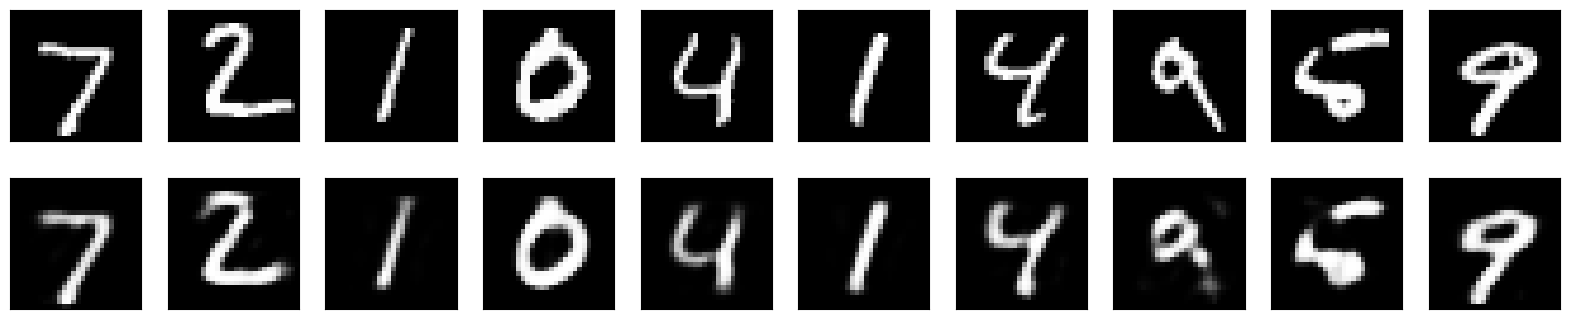

In [ ]:
reconstructed_img = autoencoder.predict(X_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Variational Autoencoder

In [ ]:
!pip install tensorflow-probability

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp
ds = tfp.distributions

/tmp/ipython-input-2086409671.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
TRAIN_BUF = 60000
TEST_BUF = 10000
BATCH_SIZE = 512
N_TRAIN_BATCHES = int(TRAIN_BUF / BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF / BATCH_SIZE)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(512)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(512)
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)
        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def loss_function(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
            loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
        )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))
        return recon_loss, latent_loss

    def gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.loss_function(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [ ]:
encoder = [
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2 * 2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model = VAE(
    enc=encoder,
    dec=decoder,
    optimizer=tf.keras.optimizers.Adam(1e-3)
)

In [ ]:
example_data = next(iter(test_dataset))

def plot_reconstruction(model, example_data, nex=8, zm=2):
    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, 2)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)
    plt.show()

In [ ]:
losses = pd.DataFrame(columns=["recon_loss", "latent_loss"])

Epoch: 49 | recon_loss: 20.3321590423584 | latent_loss: 4.665771961212158


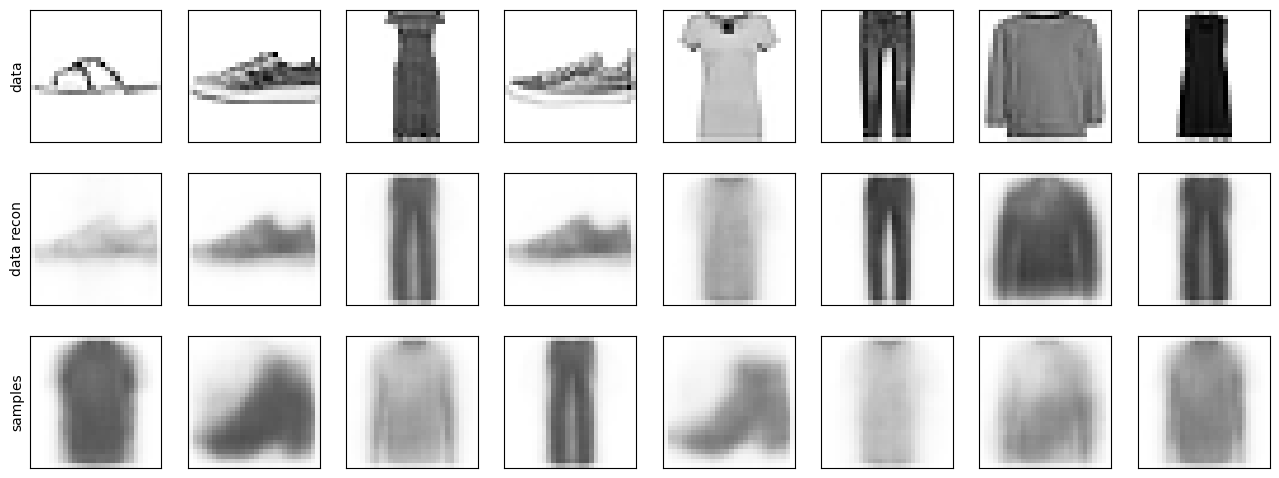

In [ ]:
n_epochs = 50
for epoch in range(n_epochs):
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)

    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.loss_function(test_x))

    losses.loc[len(losses)] = np.mean(loss, axis=0)
    display.clear_output()

    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
            epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    )
    plot_reconstruction(model, example_data)

# GAN

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape, Dense, Dropout, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.datasets import mnist
import time
from IPython import display

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

In [ ]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(7*7*256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((7, 7, 256)))
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Dropout(0.3))
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=True))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=True, activation='tanh'))
    return generator

g = create_generator()
g.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,293,505 (8.75 MB)

 Trainable params: 2,293,121 (8.75 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    return discriminator

d = create_discriminator()
d.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    final_loss = real_loss + fake_loss
    return final_loss

def G_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [ ]:
G_optimizer = tf.keras.optimizers.Adam()
D_optimizer = tf.keras.optimizers.Adam()

In [ ]:
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 256
seed = tf.random.normal([num_of_generated_examples, noise_dim])

In [ ]:
generator = create_generator()
discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    G_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    D_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='rainbow')
        plt.axis('off')

    plt.show()

In [ ]:
def train_GAN(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    if epoch % 10 == 0:
      generate_images(generator, epoch+1, seed)
    print('에포크 {} 은/는 {} 초'.format(epoch+1, time.time()-start))
  generate_images(generator, epochs, seed)

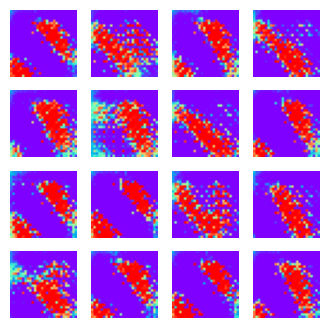

에포크 1 은/는 17.443466663360596 초
에포크 2 은/는 11.794675350189209 초
에포크 3 은/는 12.084007024765015 초
에포크 4 은/는 12.074593305587769 초
에포크 5 은/는 11.913119554519653 초
에포크 6 은/는 11.769988298416138 초
에포크 7 은/는 11.723508596420288 초
에포크 8 은/는 11.738905906677246 초
에포크 9 은/는 11.787251234054565 초
에포크 10 은/는 11.853035688400269 초


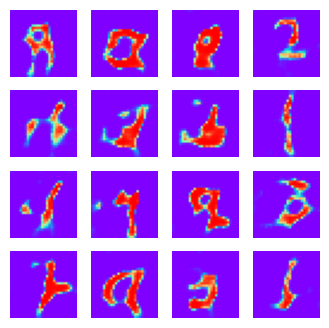

에포크 11 은/는 12.081745862960815 초
에포크 12 은/는 11.866219282150269 초
에포크 13 은/는 11.84872055053711 초
에포크 14 은/는 20.46355628967285 초
에포크 15 은/는 11.777451515197754 초
에포크 16 은/는 11.937761783599854 초
에포크 17 은/는 12.06640887260437 초
에포크 18 은/는 11.88631796836853 초
에포크 19 은/는 11.807851552963257 초
에포크 20 은/는 11.759201288223267 초


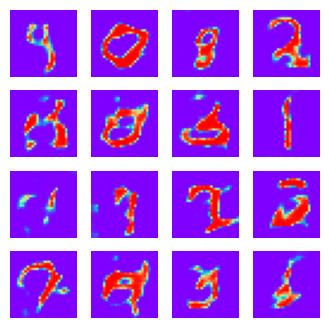

에포크 21 은/는 12.3683762550354 초
에포크 22 은/는 11.81096076965332 초
에포크 23 은/는 11.843185663223267 초
에포크 24 은/는 11.884111642837524 초
에포크 25 은/는 11.881925582885742 초
에포크 26 은/는 11.85024118423462 초
에포크 27 은/는 11.833999156951904 초
에포크 28 은/는 11.82487416267395 초
에포크 29 은/는 11.818939208984375 초
에포크 30 은/는 11.808937549591064 초


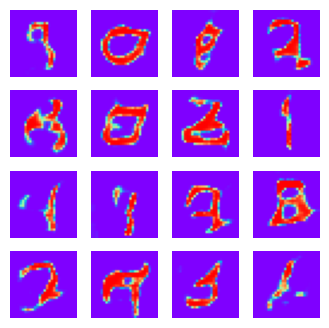

In [ ]:
train_GAN(train_dataset, 30)